# Semi-supervised Learning

We will start by having a quick look at the [semi-supervised learning algorithms included in Sklearn](https://sklearn.org/modules/label_propagation.html).

They are quite simple, and their task is to automatically label all of the unlabelled samples in a dataset:

* **Label Propagation**: Using a distance matrix, obtained using either KNN or an RBF kernel, labels are propagated to unlabelled samples using the raw distances in the matrix.
* **Label Spreading**: Minimises a loss function and iteratively propagates labels to the unlabelled samples. It is a process similar to how Spectral Clustering works.


As always, we will start by getting some data. This time we will use the `MNIST digits` dataset that we already used in Week 1, but with much higher resolution (28x28). (because of its higher resolution, it will take a little bit to download, **be patient**).

We will split it into train and test to run a quick evaluation - and in the train dataset we will set a large percentage of the labels as null (making many training data unlabelled).

With all of that, we will run several semi-supervised algorithms to automatically label the unlabelled samples and see if the accuracy starts improving by itself as more and more samples get automatically labelled.

In [1]:
import random
random.seed(42)

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

from sklearn.semi_supervised import LabelPropagation, LabelSpreading

# I chose this classifier for the tests because it is fast in training and prediction
# FEEL FREE TO USE ANY OTHER!
from sklearn.naive_bayes import MultinomialNB

In [2]:
'''
If the next lines of code don't work, run this:

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
'''
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target

X = X/255 # Quick normalisation

In [3]:
# Any number between 0 and 69999:
N_SAMPLES_FOR_TRAINING = 20000

train_x = X[:N_SAMPLES_FOR_TRAINING]
train_y = y[:N_SAMPLES_FOR_TRAINING].copy()
test_x = X[N_SAMPLES_FOR_TRAINING:]
test_y = y[N_SAMPLES_FOR_TRAINING:]

train_data = pd.DataFrame(train_x)
train_data.columns = range(train_x.shape[1])
input_features = train_data.columns

'''
REAL ACCURACY! 
This is only feasible because we have all the data labelled.
Let's calculate what is the highest accuracy we can get if we did 
"perfect automatic labelling" of all of the samples we are going to
set as unlabelled in the next code cell
'''
base_model = MultinomialNB()
base_model.fit(train_data[input_features], train_y)
print('Predicting test data...')
pred_y = base_model.predict(test_x)
print('Calculating accuracy score:')
acc = accuracy_score(test_y, pred_y)
print(' **** Real accuracy:', acc, ' **** ')

Predicting test data...
Calculating accuracy score:
 **** Real accuracy: 0.8262  **** 


In [4]:
# Perc samples unlabelled. 
# We will start with many unlabelled samples (only 0.1% labelled!)
# YES, I am setting 99.9% of the samples as unlabelled!
PERC_SAMPLES_UNLABELLED = 99.9


# Now we set to null around 95% of the train labels:
for index in range(len(train_y)):
    r = 100*random.random()
    if r <= PERC_SAMPLES_UNLABELLED:
        train_y[index] = None
        
# Now we assign this array with a lot of nulls as the target feature
train_data['target'] = train_y

In [5]:
num_unlabelled = len([i for i in train_y if not i])
print('The training data contains', len(train_x), 'samples:')
print(' * Around', PERC_SAMPLES_UNLABELLED,'% (', num_unlabelled,') of them are unlabelled')
print(' * And the remaining', len(train_x) - num_unlabelled, 'being the only labelled ones')

The training data contains 20000 samples:
 * Around 99.9 % ( 19984 ) of them are unlabelled
 * And the remaining 16 being the only labelled ones


This looks like a three:


<Figure size 432x288 with 0 Axes>

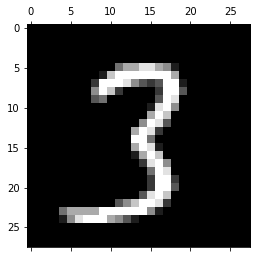

In [6]:
'''
Insert any number between 0 and 70k to visualise one training data
record. I put 3435 for example. BUT TRY SOME OTHER:
'''
SAMPLE_RECORD_NUMBER = 3435

print('This looks like a three:')
plt.gray() 
plt.matshow(X[SAMPLE_RECORD_NUMBER].reshape(28, 28)) 
plt.show() 

In [7]:
def pca_and_plot_data(train_data, tit=None):
    # We are decomposing the dataset into 2D and see how it looks like 
    pca = PCA(n_components=2)
    pca_res = pca.fit_transform(train_data[input_features])

    rows = []
    for p, s in zip(pca_res, train_data['target']):
        rows.append((p[0], p[1], s))

    pca_df = pd.DataFrame(rows, columns=['pc1', 'pc2', 'label'])

    palette = [
            '#ff6622', '#66ccff', '#bbff88', '#ff0066', '#6666ff', '#e566ff', '#66ff99', 
            '#7cb9e8', '#b0bf1a', '#3b7a57', '#967117', '#aaaaaa22'
    ]

    plt.figure(figsize=(15, 10))
    labels = set(train_y)

    data = pca_df[pca_df['label'].isnull()]
    plt.scatter(x=data['pc1'], y=data['pc2'], color=palette[-1], label='Unlabelled')

    for idx, l in enumerate(labels):
        data = pca_df[pca_df['label'] == l]
        plt.scatter(x=data['pc1'], y=data['pc2'], color=palette[idx], label=l)

    plt.title(tit)
    plt.legend()
    plt.show()

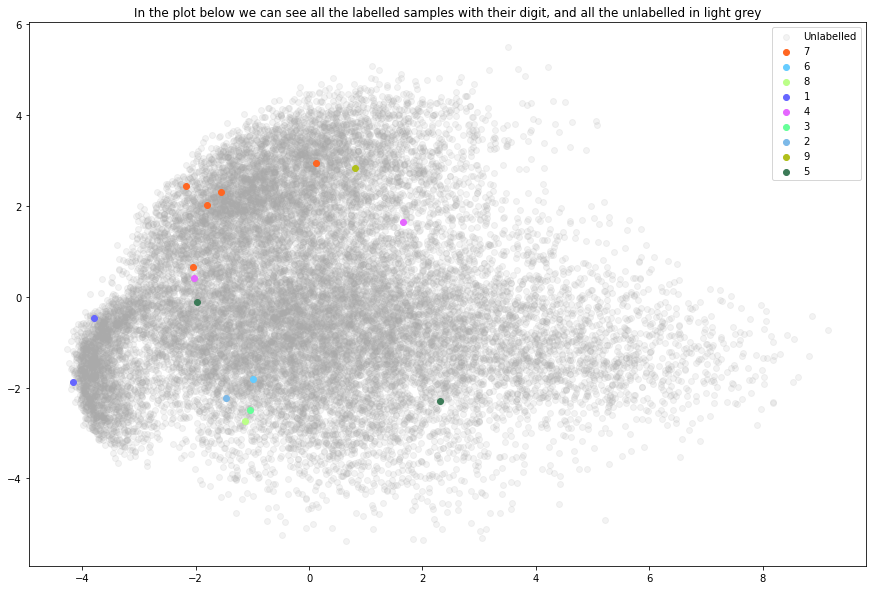

In [8]:
pca_and_plot_data(train_data, tit='In the plot below we can see all the labelled samples with their digit, and all the unlabelled in light grey')

#### 1. Performance without doing anything
Just keeping all of the unlabelled data as it is.

In [9]:
# We select the train data that is labelled (target is not null):
labelled_data = train_data[~train_data['target'].isnull()]
# We also select the unlabelled data, to use later in semi-supervised models:
unlabelled_data = train_data[train_data['target'].isnull()].copy()


model = MultinomialNB()

print('Fitting Linear Regression model...')
model.fit(labelled_data[input_features], labelled_data['target'])
print('Predicting test data...')
pred_y = model.predict(test_x)
print('Calculating accuracy score:')
acc = accuracy_score(test_y, pred_y)
print(' **** Bottomline accuracy:', acc, ' **** ')

Fitting Linear Regression model...
Predicting test data...
Calculating accuracy score:
 **** Bottomline accuracy: 0.3185  **** 


I am getting a bottomline accuracy of around 39.9%, which is much better than random (since we have 10 classes, random choice would be 10%).

### 2. Semi-supervised Learning

Let's now apply a semi-supervised learning model to automatically label the unlabelled samples. We will start with a KNN-based approach..

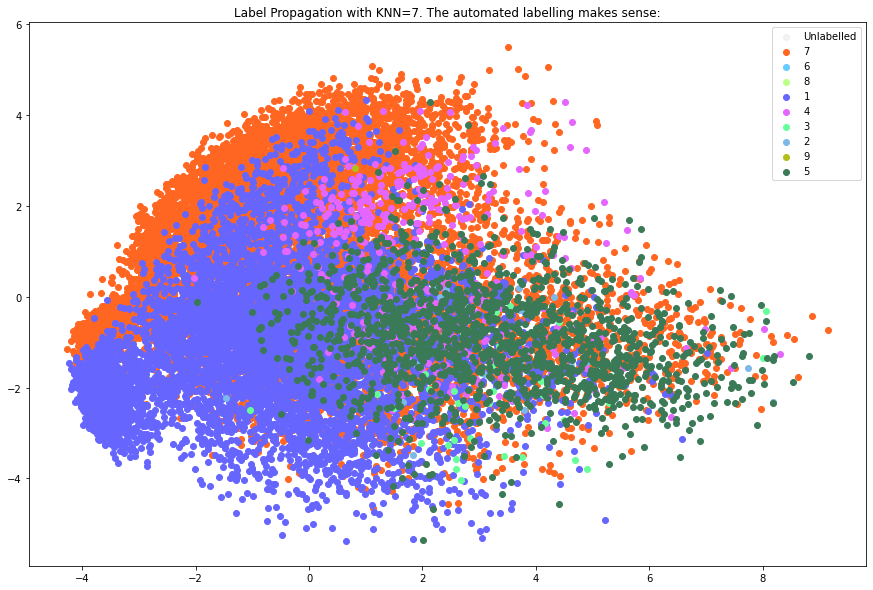

In [10]:
# ALL OF THE MODELS ARE ITERATIVE. CHANGE THE MAX_ITER PARAMETER TO SEE 
# HOW THEIR PERFORMANCE IS AFFECTED:
MAX_ITER = 1000

# ALSO, IN THIS MODEL: Change the num. neighbors! Does it improve or make it worse?
NNs = 7

lp_knn = LabelPropagation(
    kernel='knn', 
    n_neighbors=NNs, 
    max_iter=MAX_ITER, 
    n_jobs=-1
)
lp_knn.fit(labelled_data[input_features], labelled_data['target'])
unlabelled_data['target'] = lp_knn.predict(unlabelled_data[input_features])
pl_knn_df = labelled_data.append(unlabelled_data)
pca_and_plot_data(pl_knn_df, f'Label Propagation with KNN={NNs}. The automated labelling makes sense:')

In [11]:
# Let's now use our new training data (with unlabelled samples automatically labelled)!!

# We can re-fit the same model as before:
print('Fitting Linear Regression model...')
model.fit(pl_knn_df[input_features], pl_knn_df['target'])
print('Predicting test data...')
pred_y = model.predict(test_x)
print('Calculating accuracy score:')
acc = accuracy_score(test_y, pred_y)
print(' **** Bottomline accuracy:', acc, ' **** ')

Fitting Linear Regression model...
Predicting test data...
Calculating accuracy score:
 **** Bottomline accuracy: 0.27886  **** 


#### That's not really great

I am getting more or less performance than when using fewer labels. Not good. It means that our semi-supervised method didn't go well. **We could change the K-Nearest Neighbors parameter to try and get better results**
We could look into the **confusion matrix** to see which labels are being misclassified etc. And try to improve it from there... But this interactive activity is not about that!

Let's now try Label Propagation with an RBF-kernel approach:

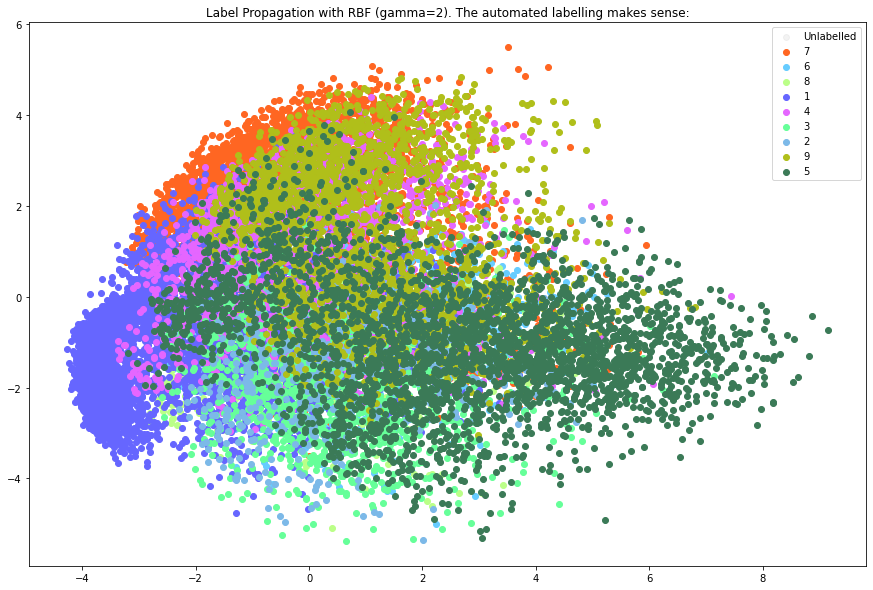

In [12]:
# We select the train data that is labelled (target is not null):
labelled_data = train_data[~train_data['target'].isnull()]
# We also select the unlabelled data, to use later in semi-supervised models:
unlabelled_data = train_data[train_data['target'].isnull()].copy()

# Change the gamma! (with gamma=20 I got horrible results)
GAMMA=2

lp_rbf = LabelPropagation(
    kernel='rbf', 
    gamma=GAMMA,
    max_iter=MAX_ITER,  
    n_jobs=-1
)
lp_rbf.fit(labelled_data[input_features], labelled_data['target'])
unlabelled_data['target'] = lp_rbf.predict(unlabelled_data[input_features])
pl_rbf_df = labelled_data.append(unlabelled_data)
pca_and_plot_data(pl_rbf_df, f'Label Propagation with RBF (gamma={GAMMA}). The automated labelling makes sense:')

In [13]:
# Let's now use our new training data (with unlabelled samples automatically labelled)!!

# We can re-fit the same model as before:
print('Fitting Linear Regression model...')
model.fit(pl_rbf_df[input_features], pl_rbf_df['target'])
print('Predicting test data...')
pred_y = model.predict(test_x)
print('Calculating accuracy score:')
acc = accuracy_score(test_y, pred_y)
print(' **** Bottomline accuracy:', acc, ' **** ')

Fitting Linear Regression model...
Predicting test data...
Calculating accuracy score:
 **** Bottomline accuracy: 0.50384  **** 


### Much better!

Here we can clearly see why: The clusters of numbers make sense in the PCA decomposition. In the previous one (KNN-based) some labels were getting too much attention. RBF is more balanced; and since our classes are more or less balanced, that is great.


### Label Spreading

Let's now try another algorithm: Label Spreading

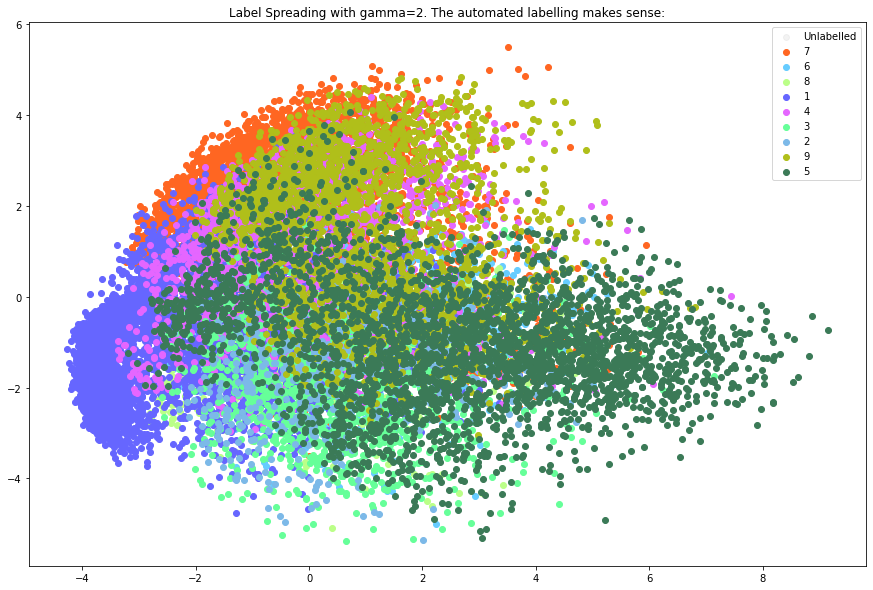

In [14]:
# We select the train data that is labelled (target is not null):
labelled_data = train_data[~train_data['target'].isnull()]
# We also select the unlabelled data, to use later in semi-supervised models:
unlabelled_data = train_data[train_data['target'].isnull()].copy()


# ANOTHER GAMMA, FEEL FREE TO CHANGE:
GAMMA=2

ls = LabelSpreading(
    kernel='rbf', # FEEL FREE TO CHANGE TO KNN AND USE N. NEIGHBORS INSTEAD OF GAMMA
    gamma=GAMMA,
    max_iter=MAX_ITER, 
    alpha=0.8, # A relatively important param in LabelSpreading. I will let you investigate it
    n_jobs=-1
)
ls.fit(labelled_data[input_features], labelled_data['target'])
unlabelled_data['target'] = ls.predict(unlabelled_data[input_features])
ls_df = labelled_data.append(unlabelled_data)
pca_and_plot_data(ls_df, f'Label Spreading with gamma={GAMMA}. The automated labelling makes sense:')

In [15]:
# We can re-fit the same model as before:
print('Fitting Linear Regression model...')
model.fit(ls_df[input_features], ls_df['target'])
print('Predicting test data...')
pred_y = model.predict(test_x)
print('Calculating accuracy score:')
acc = accuracy_score(test_y, pred_y)
print(' **** Bottomline accuracy:', acc, ' **** ')

Fitting Linear Regression model...
Predicting test data...
Calculating accuracy score:
 **** Bottomline accuracy: 0.5038  **** 


#### Similar results

We can see that LabelSpreading's results are almost identical to those of LabelPropagation with the same configuration. This is because both algorithms are very similar in reality.

**If you think about it, it is quite impressive that we can recognise about half of the digits correctly just by initially using 0.01% of the samples (around 15-20 examples).**

This is the reason why semi-supervised models are raising fast as a flexible Machine Learning paradigm that allows us to collect very few samples of data (presumably because it is quite expensive or difficult to collect) and then, with the help of many unlabelled samples, boost our performance.


# Learning Exercises

* Tweaking the semi-supervised learning algorithms, can you get anywhere close to the base accuracy? (the one we calculated at the beginning with all of the samples labelled)

* What about changing the classification algorithm, can you pass the 50% accuracy we have achieved?
